In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sp

In [2]:
tool_62 = pd.read_csv('./tool_62.csv')
tool_66 = pd.read_csv('./tool_66.csv')

In [3]:
split_62 = [pd.read_csv(f'./merged_split/62/{i}.csv') for i in range(31)] # 마지막 한개는 all cycle이 아님
split_66 = [pd.read_csv(f'./merged_split/62/{i}.csv') for i in range(27)]

### 온갖 함수

In [4]:
def filling(dataframe:pd.DataFrame):
    temp = dataframe.copy()
    temp.interpolate('linear',inplace=True)
    temp.fillna('bfill',inplace=True)
    temp.fillna('ffill',inplace=True)
    return temp

In [12]:
import pandas as pd
from scipy.stats import ttest_ind, levene
import numpy as np

def perform_t_tests(df1, df2):
    """
    두 데이터프레임의 모든 열에 대해 독립 표본 t-검정을 수행하는 함수입니다.

    Parameters:
    df1 (pandas.DataFrame): 첫 번째 데이터프레임
    df2 (pandas.DataFrame): 두 번째 데이터프레임

    Returns:
    results (pandas.DataFrame): 각 열에 대한 t-검정 결과를 포함하는 데이터프레임
    """
    # 결과를 저장할 빈 리스트를 초기화합니다.
    results = []

    # df1과 df2의 모든 열에 대해 반복합니다.
    for column in df1.columns:
        # 해당 열의 데이터를 추출합니다.
        data1 = df1[column]
        data2 = df2[column]
        data1 =filling(data1)
        data2=filling(data2)
        
        # 데이터가 충분한 경우에만 t-검정을 수행
        if len(data1) > 1 and len(data2) > 1:
            # F-테스트를 사용하여 분산 동일성 검사
            _, p_value_levene = levene(data1, data2)
            equal_var = p_value_levene > 0.05

            # 독립 표본 t-검정 수행
            t_statistic, p_value = ttest_ind(data1, data2, equal_var=equal_var)
            results.append({'Column': column, 'P': "{:.4e}".format(p_value)})
        else:
            # 데이터가 충분하지 않은 경우 결과 추가
            results.append({'Column': column, 'P': np.nan})

    # 결과 리스트를 데이터프레임으로 변환
    results_df = pd.DataFrame(results)

    # 결과 리스트를 데이터프레임으로 변환합니다.
    results_df = pd.DataFrame(results).transpose()
    results_df.columns = results_df.iloc[0,:]
    results_df.drop('Column',inplace=True)
    results
    return results_df

In [13]:
def convert_objects_to_float(df):
    """
    데이터프레임의 모든 object 타입 컬럼을 float 타입으로 변환합니다.

    Parameters:
    df (pd.DataFrame): 입력 데이터프레임

    Returns:
    pd.DataFrame: 타입이 변환된 데이터프레임
    """
    for column in df.columns:
        if df[column].dtype == 'object':
            # 숫자로 변환할 수 없는 값을 포함한 경우 오류가 발생할 수 있음
            try:
                df[column] = df[column].astype(float)
            except ValueError:
                print(f"컬럼 '{column}'을 float로 변환할 수 없습니다.")
    return df

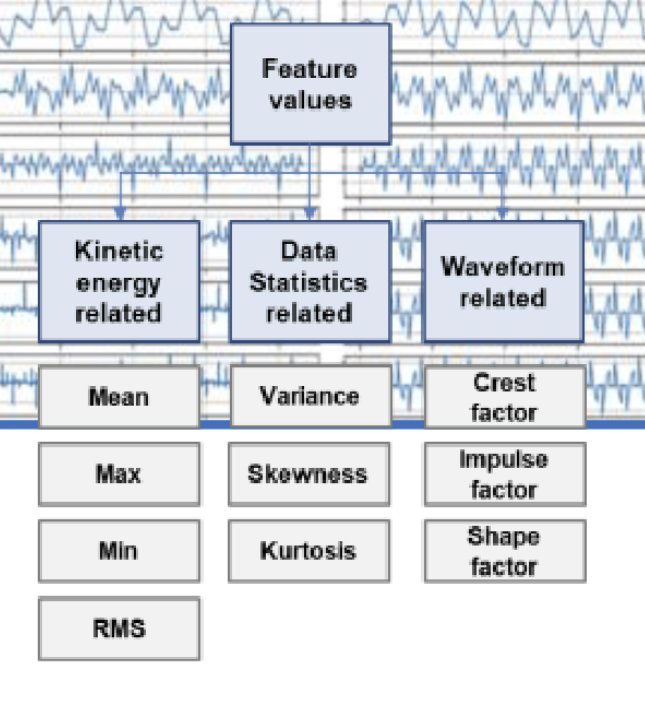

In [14]:
def rms(x):
  return np.sqrt(np.mean(x**2))

def Feature_Make(dataframe:pd.DataFrame):
  '''
  데이터프레임의 통계적인 모든 특징을 담아내는 함수
  '''
  data = filling(dataframe)
  Max = np.max(data)
  Min = np.min(data)
  Mean = np.mean(data)
  Rms = rms(data)
  Std = np.std(data)
  Skew =sp.skew(data)
  Kurt = sp.kurtosis(data)
  if Rms == 0:
    Cf = np.NaN
  else:
    Cf = Max/Rms
  if Mean==0:
    If = np.NaN
  else:
    If = Rms/Mean
  if Mean  == 0:
    Sf = 0
  else:
    Sf = Max/Mean
  Median = np.median(data)
  Mode = sp.mode(data)[0]
  q1 = np.quantile(data,0.25)
  q3 = np.quantile(data,0.75)
  Iqr = q3-q1
  List = [Max,Min,Mean,Rms,Std,Skew,Kurt,Cf,If,Sf,Median,Mode,q1,q3,Iqr]
  Domain = pd.DataFrame(List,index=['Max','Min','Mean','Rms','Std','Skew',\
                        'Kurt','Cf','If','Sf','Median','Mode','q1','q3','Iqr'])
  Domain = Domain.transpose()
  return Domain

In [15]:
def update_diff(df, threshold):
    """
    데이터프레임의 모든 컬럼에 대해 각 값이 주어진 임계값보다 작은 경우 'Diff', 나머지는 'NOPE'으로 변경합니다.

    Parameters:
    df (pd.DataFrame): 입력 데이터프레임
    threshold (float): 비교할 임계값

    Returns:
    pd.DataFrame: 업데이트된 데이터프레임
    """
    for column in df.columns:
        df[column] = df[column].apply(lambda x: 'Diff' if x < threshold else 'NOPE')
    return df
p_value = 0.05

### 62

In [16]:
jump  = 60
sec = 120
columns_to_delete = ["Active_Power_W1", "Active_Power_W2", "Active_Power_W3", "Apparent_Power_Va1",
                     "Apparent_Power_Va2", "Line_Current_L1", "Line_Current_L2", "Line_Current_L3",
                     "Line_Voltage_V23", "Line_Voltage_V31"]
columns = list(split_62[0].columns)
selected_columns = [item for item in columns if item not in columns_to_delete]
del selected_columns[0]
stat_list_front = [pd.DataFrame() for i in range(len(selected_columns))]
stat_list_second = [pd.DataFrame() for i in range(len(selected_columns))]
stat_list_third = [pd.DataFrame() for i in range(len(selected_columns))]
stat_list_back = [pd.DataFrame() for i in range(len(selected_columns))]
stat_list_back_second = [pd.DataFrame() for i in range(len(selected_columns))]


for dataframe in split_62:
    data = dataframe[selected_columns]
    front = data.iloc[jump: jump+sec,:]
    second = data.iloc[jump+sec: jump+sec*2,:]
    third = data.iloc[jump+sec*2: jump+sec*3,:]
    back = data.iloc[-jump-sec:-jump,:]
    back_second = data.iloc[-jump-sec*2:-jump-sec*1,:]
    for i, column in enumerate(selected_columns): # 앞 부분과 뒷 부분의 통계치 비교 하기 
        stat_list_front[i] = pd.concat([stat_list_front[i],Feature_Make(front[column])],axis=0)
        stat_list_back[i] = pd.concat([stat_list_back[i],Feature_Make(back[column])],axis=0)
        stat_list_second[i] = pd.concat([stat_list_second[i],Feature_Make(second[column])],axis=0)
        stat_list_third[i] = pd.concat([stat_list_third[i],Feature_Make(third[column])],axis=0)
        stat_list_back_second[i] = pd.concat([stat_list_back_second[i],Feature_Make(back_second[column])],axis=0)


['Apparent_Power_Va3', 'Line_Voltage_V12', 'x', 'y', 'z']


C:\Users\na062\AppData\Local\Temp\ipykernel_50152\3693395324.py:14: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  Skew =sp.skew(data)
C:\Users\na062\AppData\Local\Temp\ipykernel_50152\3693395324.py:15: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  Kurt = sp.kurtosis(data)


In [17]:
def total_p_value(List1:list,List2:list):
    '''
    두 부분에 대하여 각 열별 p_value를 도출한다. 
    index는 selected_columns를 
    column은 통계량을 의미한다. 
    만약에 p_value가 낮다면 이는 해당 columne에서는 어떠한 통계량을 쓰는 것이 좋은지 알 수 있다.
    '''
    p_value_columns =pd.DataFrame()
    for i in range(len(selected_columns)):
        p_value_columns = pd.concat([p_value_columns,perform_t_tests(List1[i],List2[i])])
    p_value_columns.index = selected_columns
    p_value_columns = convert_objects_to_float(p_value_columns)
    return p_value_columns

In [18]:
p_value_62_twothree = total_p_value(stat_list_second,stat_list_third)
p_value_62_twothree

Column,Max,Min,Mean,Rms,Std,Skew,Kurt,Cf,If,Sf,Median,Mode,q1,q3,Iqr
Apparent_Power_Va3,0.030417,0.30051,0.10760,0.088528,0.075279,0.676950,0.518720,0.15716,0.044736,0.126740,0.50486,0.77921,0.81454,0.025591,0.015684
Line_Voltage_V12,0.806380,0.94749,0.98428,0.984110,0.217420,0.091735,0.042488,0.16701,0.164680,0.166890,0.93059,0.85322,0.94235,0.955520,0.322120
x,0.643160,0.90645,0.96492,0.966030,0.804370,0.874100,0.772320,0.56123,0.796000,0.560650,0.94047,0.58984,0.99057,0.878870,0.735910
y,0.706070,0.73526,0.98699,0.987230,0.843580,0.797050,0.234490,0.46366,0.914590,0.462550,0.96256,0.71108,0.91689,0.955790,0.527350
z,0.098919,0.18104,0.90912,0.142160,0.145530,0.515440,0.440560,0.61616,0.048524,0.029734,0.76092,0.26948,0.59656,0.782840,0.567940


In [19]:
p_value_62_frontback=total_p_value(stat_list_front,stat_list_back)
p_value_62_frontback

Column,Max,Min,Mean,Rms,Std,Skew,Kurt,Cf,If,Sf,Median,Mode,q1,q3,Iqr
Apparent_Power_Va3,0.000555,0.73847,0.00663,0.004393,0.000504,0.525740,0.055700,0.002529,0.00057,0.00200,0.026428,0.39832,0.35836,0.004306,0.000712
Line_Voltage_V12,0.455860,0.40048,0.65437,0.654570,0.816360,0.036501,0.330990,0.258770,0.64359,0.25985,0.808880,0.82969,0.71251,0.651250,0.715520
x,0.873150,0.57119,0.70334,0.700510,0.592680,0.810210,0.549570,0.903670,0.51283,0.90597,0.809900,0.99894,0.51064,0.809740,0.436190
y,0.790960,0.53271,0.97916,0.980950,0.657970,0.472800,0.051689,0.650620,0.50048,0.65152,0.926110,0.93762,0.86201,0.845830,0.206230
z,0.948780,0.98050,0.62681,0.933530,0.985000,0.495000,0.008467,0.021507,0.84657,0.94170,0.420510,0.86800,0.68682,0.061390,0.062283


In [20]:
p_value_62_back=total_p_value(stat_list_back,stat_list_back_second)
p_value_62_back

Column,Max,Min,Mean,Rms,Std,Skew,Kurt,Cf,If,Sf,Median,Mode,q1,q3,Iqr
Apparent_Power_Va3,0.03385,0.47959,0.028298,0.023832,0.016295,0.887190,0.010445,0.137140,0.017936,0.116040,0.13896,0.69142,0.74588,0.011973,0.004218
Line_Voltage_V12,0.74983,0.78198,0.805430,0.805320,0.749830,0.940170,0.548780,0.816100,0.678540,0.815920,0.83453,0.81007,0.82492,0.711270,0.339690
x,0.42141,0.62741,0.778200,0.782080,0.591890,0.447930,0.971680,0.397000,0.525810,0.396790,0.93675,0.64858,0.97907,0.711580,0.614430
y,0.76820,0.39677,0.992960,0.992640,0.918190,0.110330,0.621330,0.616880,0.919700,0.614930,0.98228,0.43417,0.97840,0.999200,0.939170
z,0.37886,0.25035,0.123150,0.234310,0.218720,0.049329,0.248440,0.040009,0.053611,0.053165,0.67175,0.51063,0.45965,0.152080,0.109930


In [21]:
## 2분과 3분대에서는? 
update_diff(p_value_62_twothree,p_value)

Column,Max,Min,Mean,Rms,Std,Skew,Kurt,Cf,If,Sf,Median,Mode,q1,q3,Iqr
Apparent_Power_Va3,Diff,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,Diff,NOPE,NOPE,NOPE,NOPE,Diff,Diff
Line_Voltage_V12,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,Diff,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE
x,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE
y,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE
z,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,Diff,Diff,NOPE,NOPE,NOPE,NOPE,NOPE


In [22]:
update_diff(p_value_62_frontback,p_value)

Column,Max,Min,Mean,Rms,Std,Skew,Kurt,Cf,If,Sf,Median,Mode,q1,q3,Iqr
Apparent_Power_Va3,Diff,NOPE,Diff,Diff,Diff,NOPE,NOPE,Diff,Diff,Diff,Diff,NOPE,NOPE,Diff,Diff
Line_Voltage_V12,NOPE,NOPE,NOPE,NOPE,NOPE,Diff,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE
x,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE
y,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE
z,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,Diff,Diff,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE


In [23]:
update_diff(p_value_62_back,p_value)

Column,Max,Min,Mean,Rms,Std,Skew,Kurt,Cf,If,Sf,Median,Mode,q1,q3,Iqr
Apparent_Power_Va3,Diff,NOPE,Diff,Diff,Diff,NOPE,Diff,NOPE,Diff,NOPE,NOPE,NOPE,NOPE,Diff,Diff
Line_Voltage_V12,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE
x,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE
y,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE
z,NOPE,NOPE,NOPE,NOPE,NOPE,Diff,NOPE,Diff,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE


### 66

In [24]:
stat_list_front = [pd.DataFrame() for i in range(len(selected_columns))]
stat_list_second = [pd.DataFrame() for i in range(len(selected_columns))]
stat_list_third = [pd.DataFrame() for i in range(len(selected_columns))]
stat_list_back = [pd.DataFrame() for i in range(len(selected_columns))]
stat_list_back_second = [pd.DataFrame() for i in range(len(selected_columns))]
print(selected_columns)
for dataframe in split_66:
    data = dataframe[selected_columns]
    front = data.iloc[jump: jump+sec,:]
    second = data.iloc[jump+sec: jump+sec*2,:]
    third = data.iloc[jump+sec*2: jump+sec*3,:]
    back = data.iloc[-jump-sec:-jump,:]
    back_second = data.iloc[-jump-sec*2:-jump-sec*1,:]
    for i, column in enumerate(selected_columns): # 앞 부분과 뒷 부분의 통계치 비교 하기 
        stat_list_front[i] = pd.concat([stat_list_front[i],Feature_Make(front[column])],axis=0)
        stat_list_back[i] = pd.concat([stat_list_back[i],Feature_Make(back[column])],axis=0)
        stat_list_second[i] = pd.concat([stat_list_second[i],Feature_Make(second[column])],axis=0)
        stat_list_third[i] = pd.concat([stat_list_third[i],Feature_Make(third[column])],axis=0)
        stat_list_back_second[i] = pd.concat([stat_list_back_second[i],Feature_Make(back_second[column])],axis=0)

['Apparent_Power_Va3', 'Line_Voltage_V12', 'x', 'y', 'z']


C:\Users\na062\AppData\Local\Temp\ipykernel_50152\3693395324.py:14: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  Skew =sp.skew(data)
C:\Users\na062\AppData\Local\Temp\ipykernel_50152\3693395324.py:15: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  Kurt = sp.kurtosis(data)


In [25]:
p_value_66_twothree = total_p_value(stat_list_second,stat_list_third)
p_value_66_twothree

Column,Max,Min,Mean,Rms,Std,Skew,Kurt,Cf,If,Sf,Median,Mode,q1,q3,Iqr
Apparent_Power_Va3,0.004139,0.19509,0.008973,0.008651,0.023495,0.47055,0.628820,0.082017,0.024433,0.063641,0.086901,0.20706,0.059034,0.003595,0.005514
Line_Voltage_V12,0.839600,0.89252,0.924800,0.924680,0.432960,0.26182,0.060994,0.470880,0.339040,0.470580,0.966120,0.98928,0.974670,0.922420,0.587700
x,0.982200,0.84699,0.997820,0.998780,0.802710,0.95378,0.887020,0.969960,0.815340,0.970700,0.998690,0.79688,0.993890,0.930940,0.834640
y,0.730880,0.73748,0.966900,0.967260,0.775790,0.93621,0.159740,0.494980,0.844560,0.494230,0.987220,0.40531,0.884110,0.960540,0.416450
z,0.088202,0.21756,0.829900,0.133940,0.137230,0.84017,0.455250,0.582190,0.051318,0.029624,0.721940,0.41613,0.234910,0.632110,0.242190


In [26]:
p_value_66_frontback = total_p_value(stat_list_front,stat_list_back)
p_value_66_frontback

Column,Max,Min,Mean,Rms,Std,Skew,Kurt,Cf,If,Sf,Median,Mode,q1,q3,Iqr
Apparent_Power_Va3,0.000577,0.60797,0.005305,0.003309,0.00031,0.476520,0.065184,0.002474,0.000377,0.001956,0.012348,0.16279,0.33487,0.003531,0.000517
Line_Voltage_V12,0.378440,0.36099,0.577050,0.577230,0.84712,0.034667,0.483540,0.220700,0.655630,0.221710,0.726860,0.74484,0.64404,0.570350,0.645620
x,0.819560,0.68836,0.809380,0.807010,0.71960,0.868010,0.545730,0.901880,0.608030,0.899270,0.894110,0.90402,0.63199,0.877880,0.563290
y,0.969010,0.59794,0.959000,0.960390,0.76272,0.918450,0.011600,0.996810,0.574610,0.998990,0.917980,0.43745,0.91530,0.831950,0.249520
z,0.855070,0.98573,0.726190,0.875440,0.93732,0.237820,0.002322,0.018880,0.853000,0.939140,0.546910,0.81965,0.74141,0.108880,0.087533


In [27]:
p_value_66_back=total_p_value(stat_list_back,stat_list_back_second)
p_value_66_back

Column,Max,Min,Mean,Rms,Std,Skew,Kurt,Cf,If,Sf,Median,Mode,q1,q3,Iqr
Apparent_Power_Va3,0.021929,0.477560,0.012713,0.010193,0.007925,0.864930,0.011222,0.117780,0.008649,0.096297,0.059346,0.76449,0.83319,0.00403,0.001226
Line_Voltage_V12,0.730450,0.817230,0.796730,0.796600,0.671950,0.821810,0.912280,0.778260,0.641580,0.778080,0.816270,0.74756,0.82061,0.69383,0.280360
x,0.479640,0.495680,0.856990,0.860300,0.624390,0.811550,0.800480,0.389770,0.575740,0.389270,0.951110,0.52722,0.99478,0.84160,0.742810
y,0.964440,0.458920,0.980990,0.980150,0.787970,0.189550,0.297580,0.959440,0.798090,0.958070,0.988770,0.27311,0.99776,0.97767,0.936690
z,0.164820,0.094934,0.132960,0.087874,0.080758,0.081975,0.087830,0.016532,0.022755,0.018754,0.699040,0.22036,0.27129,0.14692,0.064999


In [28]:
update_diff(p_value_66_twothree,p_value)

Column,Max,Min,Mean,Rms,Std,Skew,Kurt,Cf,If,Sf,Median,Mode,q1,q3,Iqr
Apparent_Power_Va3,Diff,NOPE,Diff,Diff,Diff,NOPE,NOPE,NOPE,Diff,NOPE,NOPE,NOPE,NOPE,Diff,Diff
Line_Voltage_V12,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE
x,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE
y,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE
z,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,Diff,NOPE,NOPE,NOPE,NOPE,NOPE


In [29]:
update_diff(p_value_66_frontback,p_value)

Column,Max,Min,Mean,Rms,Std,Skew,Kurt,Cf,If,Sf,Median,Mode,q1,q3,Iqr
Apparent_Power_Va3,Diff,NOPE,Diff,Diff,Diff,NOPE,NOPE,Diff,Diff,Diff,Diff,NOPE,NOPE,Diff,Diff
Line_Voltage_V12,NOPE,NOPE,NOPE,NOPE,NOPE,Diff,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE
x,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE
y,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,Diff,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE
z,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,Diff,Diff,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE


In [30]:
update_diff(p_value_66_back,p_value)

Column,Max,Min,Mean,Rms,Std,Skew,Kurt,Cf,If,Sf,Median,Mode,q1,q3,Iqr
Apparent_Power_Va3,Diff,NOPE,Diff,Diff,Diff,NOPE,Diff,NOPE,Diff,NOPE,NOPE,NOPE,NOPE,Diff,Diff
Line_Voltage_V12,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE
x,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE
y,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE
z,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,NOPE,Diff,Diff,Diff,NOPE,NOPE,NOPE,NOPE,NOPE
